In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as mplstyle
mplstyle.use('fast')
import ompy as om
om.print_status()


                OMpy Status
Version:              2.0.0.dev0+1b43952
Git version:          1b43952c5596668c1178579f614249d998dfd0c5
GPU available:        OK
NUMBA available:      OK
NUMBA CUDA available: OK
NUMBA CUDA working:   OK
ROOT available:       OK
ROOT imported:        OK
MINUIT available:     OK
JAX available:        OK
JAX working:          OK
H5PY available:       OK
XARRAY available:     OK
GAMBIT available:     NO
EMCEE available:      OK
PYMC available:       NO
PYRO available:       NO
SKLEARN available:    OK

Platform:             Linux-6.5.9-arch2-1-x86_64-with-glibc2.38
CPU:                  AMD Ryzen 9 5900X 12-Core Processor
  + architecture:     64bit
  + number:           24
  + frequency:        2927.91 MHz
Total memory:         62.72 GB
Available memory:     51.45 GB
        
JAX version:          0.4.9
JAXlib version:       0.4.9

Available GPUs:       1
  + kind:             NVIDIA GeForce RTX 3070 Ti



Load the matrix. OMpy defaults to numpy `.npz` files, but MAMA `.m`, ROOT files and others are supported.

In [21]:
mat = om.Matrix.from_path('120Sn_raw_without_bg.npz')

(<Axes: xlabel='$\\gamma$-energy [$\\mathrm{keV}$]', ylabel='Excitation energy [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f86f1fadcd0>,
  <matplotlib.colorbar.Colorbar at 0x7f871c7e7ad0>))

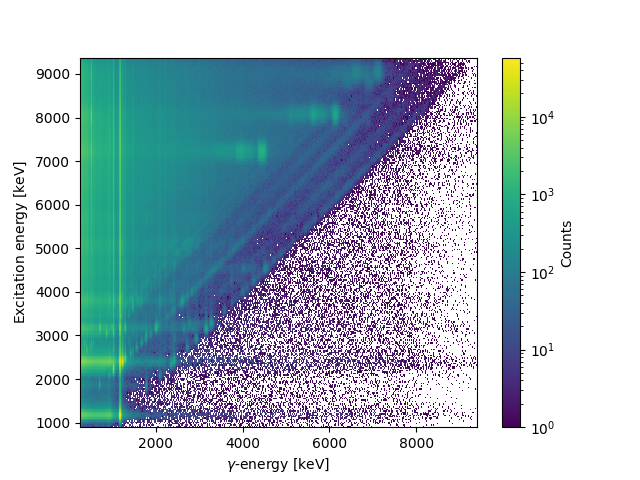

In [22]:
mat.plot()

We don't want to include counts after the diagonal. The diagonal is defined as $Ex = Eg + n\sigma(Eg, Ex)$. As a simplification, we use a line-by-eye to create a mask.

(<Axes: xlabel='$\\gamma$-energy [$\\mathrm{keV}$]', ylabel='Excitation energy [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f86f020fa50>,
  <matplotlib.colorbar.Colorbar at 0x7f86f03054d0>))

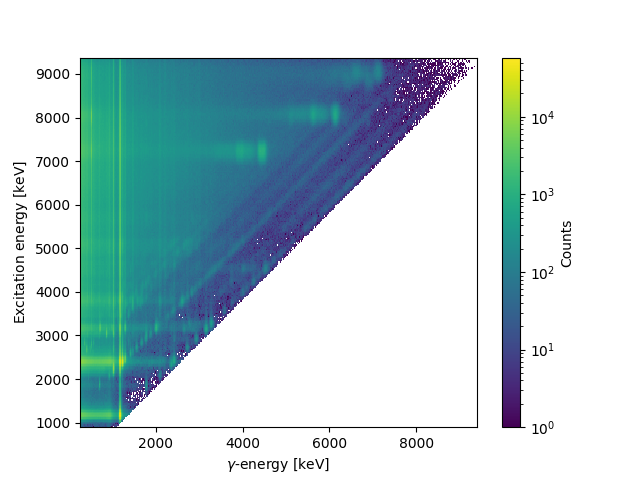

In [30]:
line = om.Line(p1=(450.0, 250.0), slope=1)
mask = line.below(mat)
mat[mask] = 0
mat.plot()

Get the response matrix. 

In [31]:
resp = om.response.Response.from_db('Oscar2020')

Version mismatch when loading /home/erdos/gits/ompydock/data/response/OSCAR2020/data/compton.npz: 2.0.0.dev0+b7d23b4 != 2.0.0.dev0+1b43952
Version mismatch when loading /home/erdos/gits/ompydock/data/response/OSCAR2020/compton.npz: 2.0.0.dev0+b7d23b4 != 2.0.0.dev0+1b43952


The discrete response matrix `R` and the smoothing matrix for $\sigma_{\text{Eg}}$ `G` are constructed by specializing the response to a matrix

In [36]:
R = resp.specialize_like(mat)
G = resp.gaussian_like(mat)

(<Axes: title={'center': 'Detector resolution'}, xlabel='Observed [$\\mathrm{keV}$]', ylabel='True [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f86e336a610>,
  <matplotlib.colorbar.Colorbar at 0x7f86e33b6bd0>))

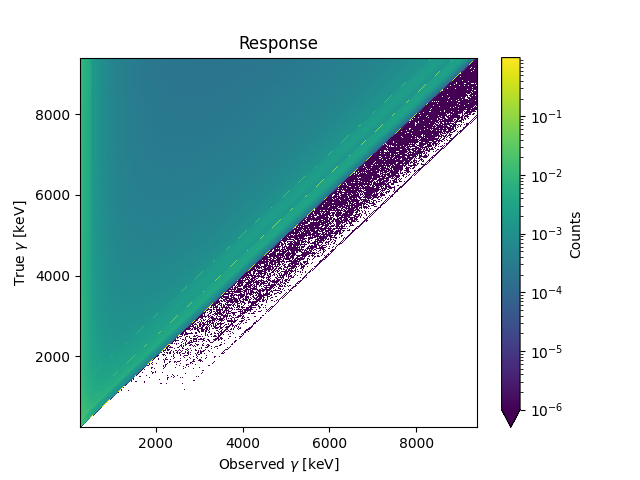

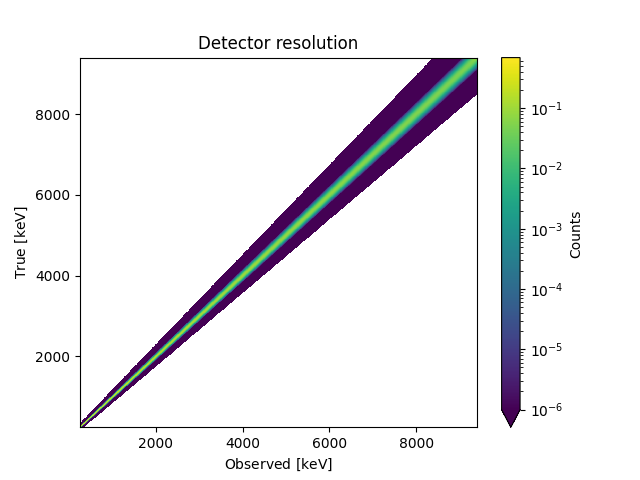

In [37]:
R.plot()
G.plot()

Since $R$ maps $\mu \to \delta$ and $G$ maps $\delta \to \nu$ (or $\mu \to \eta$), the map $\mu \to \nu$ is given by $GR$.

(<Axes: xlabel='Observed $\\gamma$ [$\\mathrm{keV}$]', ylabel='True [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f86e2f87b50>,
  <matplotlib.colorbar.Colorbar at 0x7f86e2fbb4d0>))

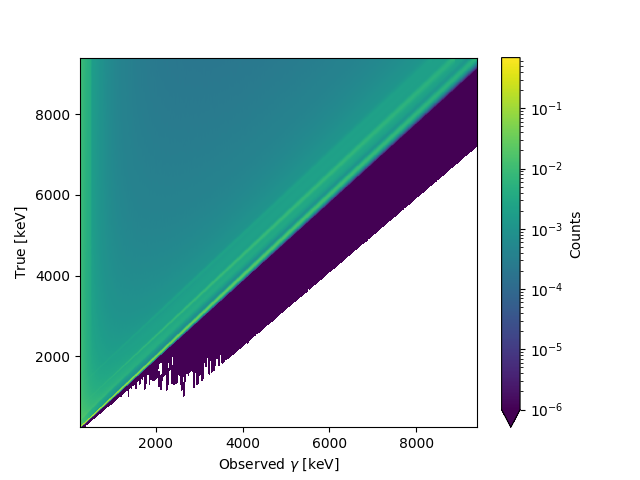

In [38]:
GR = G@R
GR.plot()

As creating $G$ and $R$ is so common, the unfolders using the `Unfolder` interace accepts a `Response` instance.
Unfolding using Guttormsen iteration is fast and converges to maximum likelihood if noise is low and the response is perfect. In order to use the mapping trick, unfolding to $\eta$ to lift the degeneracy of $G$, we specify the unfolder to use the response $R$ to unfold. The folding by $G$ is handled behind the scenes.

In [52]:
unf = om.unfolding.Guttormsen.from_response(resp, mat)
res = unf.unfold(mat, R='R', iterations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([<Axes: title={'center': 'Raw'}>,
        <Axes: title={'center': 'Folded'}>,
        <Axes: title={'center': 'unfolded'}>], dtype=object),
 [(<matplotlib.collections.QuadMesh at 0x7f84e8312790>, None),
  (<matplotlib.collections.QuadMesh at 0x7f84e81d1850>, None),
  (<matplotlib.collections.QuadMesh at 0x7f84e81d2910>,
   <matplotlib.colorbar.Colorbar at 0x7f84e813ea50>)])

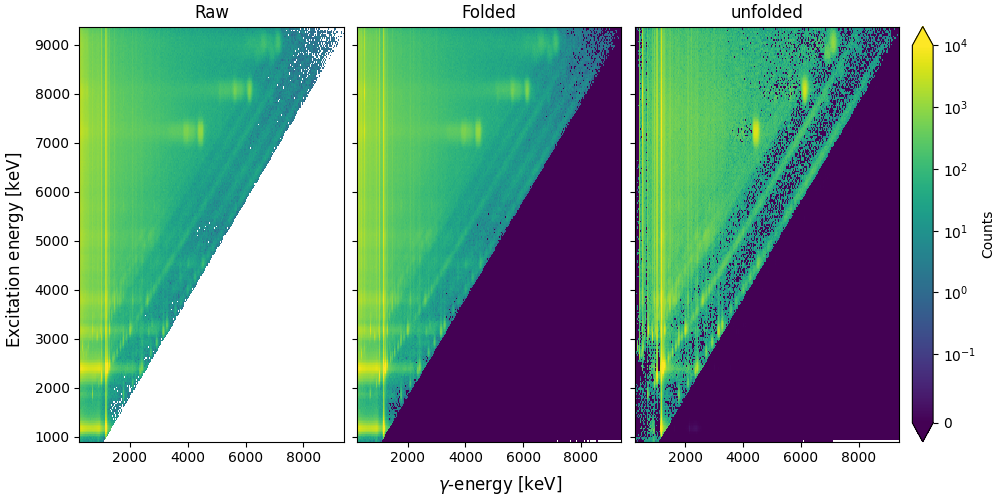

In [53]:
res.plot_comparison(vmin=0, vmax=1e4)

There are many negative counts, indicating that the response is wrong (here too low compton).